# Python: Static Panel Models with Fixed Effects

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate treatment effects for static panel models with fixed effects in a partially linear panel regression [DoubleMLPLPR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-models-plm) model. The model is based on [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011).

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor

from doubleml.data import DoubleMLPanelData
from doubleml.plm.datasets import make_plpr_CP2025
from doubleml import DoubleMLPLPR

import warnings
warnings.filterwarnings("ignore")

## Data

We will use the implemented data generating process [make_plpr_CP2025](https://docs.doubleml.org/stable/api/datasets.html#dataset-generators) to generate data similar to the simulation in [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011). For exposition, we use the simple linear `dgp_type="dgp1"`, with 150 units, 10 time periods per unit, and a true treatment effect of `theta=0.5`.

We set `time_type="int"` such that the time variable values will be integers. It's also possible to use `"float"` or `"datetime"` time variables with [DoubleMLPLPR](https://docs.doubleml.org/stable/api/dml_models.html#doubleml-plm).

In [2]:
np.random.seed(123)
data = make_plpr_CP2025(num_id=150, num_t=10, dim_x=30, theta=0.5, dgp_type="dgp1", time_type="int")
data.head()

,id,time,y,d,x1,x2,x3,x4,x5,x6,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,1,1,-1.290479,0.908307,1.710715,-1.853675,-1.473907,1.366514,-0.322024,2.944020,...,-1.828362,-3.010547,-0.840202,-3.085159,1.169952,-0.954107,-3.925198,-0.779510,-0.430700,1.004298
1,1,2,-2.850646,-1.316777,-0.325043,4.178599,-1.159857,-0.139527,-0.230115,-0.631976,...,-0.724172,-0.421045,-2.012480,-2.081784,-2.734123,-0.879470,-2.141218,4.598401,-4.222797,-2.523024
2,1,3,-4.338502,-1.756120,-0.897590,1.505972,-0.925189,1.511500,-2.206561,0.132579,...,1.766109,-2.252858,-2.919826,-1.974066,-0.773881,0.244633,-1.727550,1.665467,0.562291,-1.553616
3,1,4,-2.713236,0.934866,1.987849,2.596228,-0.220666,-0.480717,-3.966273,-0.911226,...,0.856124,0.727759,-0.501579,1.077504,2.268052,-3.821422,1.629055,-0.220834,-1.185091,-5.462884
4,1,5,-5.782997,-4.357881,-3.086559,3.796975,-1.539641,-2.425617,-1.020599,-1.666200,...,2.617215,-1.231835,-0.891350,0.246981,2.489642,0.319735,-2.810366,0.585826,3.643749,0.147147


To create a corresponding [DoubleMLPanelData](https://docs.doubleml.org/stable/api/generated/doubleml.data.DoubleMLPanelData.html) object, we need to set `static_panel=True` and specify `id_col` and `time_col` columns.

In [3]:
data_obj = DoubleMLPanelData(data, y_col="y", d_cols="d", t_col="time", id_col="id", static_panel=True)

## Model

The partially linear panel regression (PLPR) model extends the partially linear model to panel data by introducing fixed effects $\alpha_i^*$.

The PLPR model takes the form

$$
\begin{align*}
    Y_{it} &= \theta_0 D_{it} + g_1(X_{it}) + \alpha_i^* + U_{it}, \\
    D_{it} &= m_1(X_{it}) + \gamma_i + V_{it},
\end{align*}
$$

where
- $Y_{it}$ outcome, $D_{it}$ treatment, $X_{it}$ covariates, $\theta_0$ causal treatment effect
- $g_1$ and $m_1$ nuisance functions
- $\alpha_i^*$, $\gamma_i$ unobserved individual heterogeneity, correlated with covariates
- $U_{it}$, $V_{it}$ error terms

Further note $\mathbb{E}[U_{it} \mid D_{it}, X_{it}, \alpha_i^*] = 0$ and $\mathbb{E}[V_{it} \mid X_{it}, \gamma_i]=0$, but $\mathbb{E}[\alpha_i^* \mid D_{it}, X_{it}] \neq 0$.

Alternatively we can write the partialling-out PLPR as 

$$
\begin{align*}
    Y_{it} &= \theta_0 V_{it} + \ell_1(X_{it}) + \alpha_i + U_{it}, \\
    V_{it} &= D_{it} - m_1(X_{it}) - \gamma_i,
\end{align*}
$$

with nuisance function $\ell_1$ and fixed effect $\alpha_i$.

### Assumptions

Define $\xi_i$ as time-invariant heterogeneity terms influencing outcome and treatment and $L_{t-1}(W_i) = \{ W_{i1}, \dots, W_{it-1} \}$ as lags of a random variable $W_{it}$ at wave $t$.

- *No feedback to predictors*
$$ X_{it} \perp L_{t-1} (Y_i, D_i) \mid L_{t-1} (X_i), \xi_i $$
- *Static panel*
$$ Y_{it}, D_{it} \perp L_{t-1} (Y_i, X_i, D_i) \mid X_{it}, \xi_i $$
- *Selection on observables and omitted time-invariant variables*
$$ Y_{it} (.) \perp D_{it} \mid X_{it}, \xi_i $$
- *Homogeneity and linearity of the treatment effect*
$$ \mathbb{E} [Y_{it}(d) - Y_{it}(0) \mid X_{it}, \xi_i] = d \theta_0 $$
- *Additive Separability*
$$
\begin{align*}
\mathbb{E} [Y_{it}(0) \mid X_{it}, \xi_i] &= g_1(X_{it}) + \alpha^*_i \quad \text{where } \alpha^*_i = \alpha^*(\xi_i), \\
\mathbb{E} [D_{it} \mid X_{it}, \xi_i] &= m_1(X_{it}) + \gamma_i \quad \text{where } \gamma_i = \gamma(\xi_i)
\end{align*}
$$

For more information, see [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011).

To estimate the causal effect, we can create a [DoubleMLPLPR](https://docs.doubleml.org/stable/api/dml_models.html#doubleml-plm) object. The model described in [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011) uses block-k-fold cross-fitting, where the entire time series of the sampled unit is allocated to one fold to allow for possible serial correlation within each unit which is common with panel data. Furthermore, cluster robust standard error are employed. [DoubleMLPLPR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-models-plm) implements both aspects by using `id_col` as the cluster variable.

## Estimation Approaches

[Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011) describes multiple estimation approaches, which can be set with the `approach` parameter. Depending on the type of `approach`, different data transformations are performed along the way.

### Correlated Random Effects

The correlated random effects (cre) approaches includes the a general approach (`cre_general`) and  an approach relying on normality assumptions (`cre_normal`).

#### `cre_general`

The `cre_general` approach:

- Learning $\ell_1$ from $\{ Y_{it}, X_{it}, \bar{X}_i : t=1,\dots, T \}_{i=1}^N$.
- First learning $\tilde{m}_1$ from $\{ D_{it}, X_{it}, \bar{X}_i : t=1,\dots, T \}_{i=1}^N$, with predictions $\hat{m}_{1,it} = \tilde{m}_1 (X_{it}, \bar{X}_i)$
    - Calculate $\hat{\bar{m}}_i = T^{-1} \sum_{t=1}^T \hat{m}_{1,it}$,
    - Calculate final nuisance part as $\hat{m}^*_1 (X_{it}, \bar{X}_i, \bar{D}_i) = \hat{m}_{1,it} + \bar{D}_i - \hat{\bar{m}}_i$.

In [4]:
learner = LassoCV()
ml_l = clone(learner)
ml_m = clone(learner)

dml_plpr_cre_general = DoubleMLPLPR(data_obj, ml_l=ml_l, ml_m=ml_m, approach="cre_general", n_folds=5)

We can look at the the transformed data using the `data_transform` property after the `DoubleMLPLPR` object was created.

In [5]:
dml_plpr_cre_general.data_transform.data.head()

,id,time,y,d,x1,x2,x3,x4,x5,x6,...,x21_mean,x22_mean,x23_mean,x24_mean,x25_mean,x26_mean,x27_mean,x28_mean,x29_mean,x30_mean
0,1,1,-1.290479,0.908307,1.710715,-1.853675,-1.473907,1.366514,-0.322024,2.944020,...,1.24018,-0.52821,-0.734145,0.227494,1.164763,0.412979,-1.272608,0.459816,-0.829863,-1.145189
1,1,2,-2.850646,-1.316777,-0.325043,4.178599,-1.159857,-0.139527,-0.230115,-0.631976,...,1.24018,-0.52821,-0.734145,0.227494,1.164763,0.412979,-1.272608,0.459816,-0.829863,-1.145189
2,1,3,-4.338502,-1.756120,-0.897590,1.505972,-0.925189,1.511500,-2.206561,0.132579,...,1.24018,-0.52821,-0.734145,0.227494,1.164763,0.412979,-1.272608,0.459816,-0.829863,-1.145189
3,1,4,-2.713236,0.934866,1.987849,2.596228,-0.220666,-0.480717,-3.966273,-0.911226,...,1.24018,-0.52821,-0.734145,0.227494,1.164763,0.412979,-1.272608,0.459816,-0.829863,-1.145189
4,1,5,-5.782997,-4.357881,-3.086559,3.796975,-1.539641,-2.425617,-1.020599,-1.666200,...,1.24018,-0.52821,-0.734145,0.227494,1.164763,0.412979,-1.272608,0.459816,-0.829863,-1.145189


We can see that the covariates inlcude the original $X_{it}$ and additionally the unit mean $\bar{X}_i$.

After fitting the model, we can print the `DoubleMLPLPR` object. The data summary corresponds to the transformed data. Additional Information at the end also includes a pre-transformation data summary.

In [6]:
dml_plpr_cre_general.fit()
print(dml_plpr_cre_general)

================== DoubleMLPLPR Object ==================

------------------ Data Summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x1_mean', 'x2_mean', 'x3_mean', 'x4_mean', 'x5_mean', 'x6_mean', 'x7_mean', 'x8_mean', 'x9_mean', 'x10_mean', 'x11_mean', 'x12_mean', 'x13_mean', 'x14_mean', 'x15_mean', 'x16_mean', 'x17_mean', 'x18_mean', 'x19_mean', 'x20_mean', 'x21_mean', 'x22_mean', 'x23_mean', 'x24_mean', 'x25_mean', 'x26_mean', 'x27_mean', 'x28_mean', 'x29_mean', 'x30_mean']
Instrument variable(s): None
Time variable: time
Id variable: id
Static panel data: True
No. Unique Ids: 150
No. Observations: 1500

------------------ Score & Algorithm ------------------
Score function: partialling out
Static panel model approach: cre_general

--------

#### `cre_normal`

The `cre_normal` approach:

Under the assumption that the conditional distribution $D_{i1}, \dots, D_{iT} \mid X_{i1}, \dots X_{iT}$ is multivariate normal (see [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011) for further details):
- Learn $\ell_1$ from $\{ Y_{it}, X_{it}, \bar{X}_i : t=1,\dots, T \}_{i=1}^N$,
- Learn $m^*_{1}$ from $\{ D_{it}, X_{it}, \bar{X}_i, \bar{D}_i: t=1,\dots, T \}_{i=1}^N$.

In [7]:
dml_plpr_cre_normal = DoubleMLPLPR(data_obj, ml_l=ml_l, ml_m=ml_m, approach="cre_normal", n_folds=5)
dml_plpr_cre_normal.fit()
print(dml_plpr_cre_normal.summary)

       coef   std err          t         P>|t|    2.5 %    97.5 %
d  0.505807  0.027168  18.617927  2.299468e-77  0.45256  0.559055


The `cre_normal` approach uses additionally inlcudes $\bar{D}_i$ in the treatment nuisance estimation. The corresponding data can be assesses by the `d_mean` property.

In [8]:
dml_plpr_cre_normal.d_mean

array([[-0.94278854],
       [-0.94278854],
       [-0.94278854],
       ...,
       [ 0.15320478],
       [ 0.15320478],
       [ 0.15320478]], shape=(1500, 1))

### Transformation Approaches

The transformation approaches include first differences (`fd_exact`) and within-group (`wg_approx`) transformations.

#### `fd_exact`

Consider first differences (FD) transformation (`fd_exact`) $Q(Y_{it})= Y_{it} - Y_{it-1}$, under the assumptions from above, [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011) show that $\mathbb{E}[Y_{it}-Y_{it-1} | X_{it-1},X_{it}] =\Delta \ell_1 (X_{it-1}, X_{it})$ and $\mathbb{E}[D_{it}-D_{it-1} | X_{it-1},X_{it}] =\Delta m_1 (X_{it-1}, X_{it})$. Therefore, the transformed nuisance function can be learnt as

- $\Delta \ell_1 (X_{it-1}, X_{it})$ from $\{ Y_{it}-Y_{it-1}, X_{it-1}, X_{it} : t=2, \dots , T \}_{i=1}^N$,
- $\Delta m_1 (X_{it-1}, X_{it})$ from $\{ D_{it}-D_{it-1}, X_{it-1}, X_{it} : t=2, \dots , T \}_{i=1}^N$.

In [9]:
dml_plpr_fd_exact = DoubleMLPLPR(data_obj, ml_l=ml_l, ml_m=ml_m, approach="fd_exact", n_folds=5)
dml_plpr_fd_exact.data_transform.data.head()

,id,time,y_diff,d_diff,x1,x2,x3,x4,x5,x6,...,x21_lag,x22_lag,x23_lag,x24_lag,x25_lag,x26_lag,x27_lag,x28_lag,x29_lag,x30_lag
0,1,2,-1.560167,-2.225084,-0.325043,4.178599,-1.159857,-0.139527,-0.230115,-0.631976,...,-1.828362,-3.010547,-0.840202,-3.085159,1.169952,-0.954107,-3.925198,-0.779510,-0.430700,1.004298
1,1,3,-1.487856,-0.439343,-0.897590,1.505972,-0.925189,1.511500,-2.206561,0.132579,...,-0.724172,-0.421045,-2.012480,-2.081784,-2.734123,-0.879470,-2.141218,4.598401,-4.222797,-2.523024
2,1,4,1.625266,2.690986,1.987849,2.596228,-0.220666,-0.480717,-3.966273,-0.911226,...,1.766109,-2.252858,-2.919826,-1.974066,-0.773881,0.244633,-1.727550,1.665467,0.562291,-1.553616
3,1,5,-3.069761,-5.292747,-3.086559,3.796975,-1.539641,-2.425617,-1.020599,-1.666200,...,0.856124,0.727759,-0.501579,1.077504,2.268052,-3.821422,1.629055,-0.220834,-1.185091,-5.462884
4,1,6,-1.094799,0.551051,0.289315,-2.823134,-3.137179,-1.425923,-0.730116,0.232687,...,2.617215,-1.231835,-0.891350,0.246981,2.489642,0.319735,-2.810366,0.585826,3.643749,0.147147


We see that the outcome and treatment variables are now labeled `y_diff` and `d_diff` to indicate the first-difference transformation. Moreover, lagged covariates $X_{it-1}$ are added and rows for the first time period are dropped.

In [10]:
dml_plpr_fd_exact.fit()
print(dml_plpr_fd_exact.summary)

            coef   std err          t         P>|t|     2.5 %    97.5 %
d_diff  0.511822  0.032746  15.630162  4.536510e-55  0.447641  0.576002


#### `wg_approx`

For within-group (WG) transformation (`wg_approx`) $Q(X_{it})= X_{it} - \bar{X}_{i}$, where $\bar{X}_{i} = T^{-1} \sum_{t=1}^T X_{it}$, approximate the model as

$$
\begin{align*}
    Q(Y_{it}) &\approx \theta_0 Q(D_{it}) + g_1 (Q(X_{it})) + Q(U_{it}), \\
    Q(D_{it}) &\approx m_1 (Q(X_{it})) + Q(V_{it}).
\end{align*}
$$

Similarly for the partialling-out PLPR

$$
Q(Y_{it}) \approx \theta_0 Q(V_{it}) + \ell_1 (Q(X_{it})) + Q(U_{it}).
$$

- $\ell_1$ can be learnt from transformed data $\{ Q(Y_{it}), Q(X_{it}) : t=1,\dots,T \}_{i=1}^N$,
- $m_1$ can be learnt from transformed data $\{ Q(D_{it}), Q(X_{it}) : t=1,\dots,T \}_{i=1}^N$.

In [11]:
dml_plpr_wg_approx = DoubleMLPLPR(data_obj, ml_l=ml_l, ml_m=ml_m, approach="wg_approx", n_folds=5)
dml_plpr_wg_approx.data_transform.data.head()

,id,time,y_demean,d_demean,x1_demean,x2_demean,x3_demean,x4_demean,x5_demean,x6_demean,...,x21_demean,x22_demean,x23_demean,x24_demean,x25_demean,x26_demean,x27_demean,x28_demean,x29_demean,x30_demean
0,1,1,1.543571,1.760660,2.207607,-2.039516,-0.642847,1.014204,0.384166,1.826013,...,-3.162933,-2.475942,0.000728,-3.344219,0.082829,-1.351303,-2.670511,-1.275344,0.407596,2.187878
1,1,2,-0.016596,-0.464424,0.171849,3.992759,-0.328797,-0.491837,0.476074,-1.749982,...,-2.058743,0.113560,-1.171550,-2.340844,-3.821246,-1.276666,-0.886531,4.102567,-3.384501,-1.339444
2,1,3,-1.504452,-0.903767,-0.400698,1.320131,-0.094129,1.159190,-1.500371,-0.985427,...,0.431538,-1.718253,-2.078895,-2.233126,-1.861004,-0.152563,-0.472863,1.169632,1.400587,-0.370036
3,1,4,0.120814,1.787219,2.484741,2.410387,0.610394,-0.833027,-3.260084,-2.029232,...,-0.478447,1.262364,0.339352,0.818443,1.180930,-4.218618,2.883741,-0.716668,-0.346795,-4.279304
4,1,5,-2.948947,-3.505528,-2.589667,3.611134,-0.708582,-2.777927,-0.314410,-2.784206,...,1.282645,-0.697230,-0.050420,-0.012080,1.402519,-0.077461,-1.555679,0.089991,4.482045,1.330727


We see that the outcome, treatment and covariate variables are now labeled `y_deman`, `d_deman`, `xi_deman` to indicate the within-group transformations.

In [12]:
dml_plpr_wg_approx.fit()
print(dml_plpr_wg_approx.summary)

              coef   std err          t         P>|t|     2.5 %    97.5 %
d_demean  0.495323  0.025841  19.167824  6.872435e-82  0.444675  0.545972


For the simple linear data generating process `dgp_type="dgp1"`, we can see that all approaches lead to estimated close the true effect of `theta=0.5`.

The `data_original` property additionally includes the original data before any transformation was applied.

In [13]:
dml_plpr_wg_approx.data_original.data.head()

,id,time,y,d,x1,x2,x3,x4,x5,x6,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,1,1,-1.290479,0.908307,1.710715,-1.853675,-1.473907,1.366514,-0.322024,2.944020,...,-1.828362,-3.010547,-0.840202,-3.085159,1.169952,-0.954107,-3.925198,-0.779510,-0.430700,1.004298
1,1,2,-2.850646,-1.316777,-0.325043,4.178599,-1.159857,-0.139527,-0.230115,-0.631976,...,-0.724172,-0.421045,-2.012480,-2.081784,-2.734123,-0.879470,-2.141218,4.598401,-4.222797,-2.523024
2,1,3,-4.338502,-1.756120,-0.897590,1.505972,-0.925189,1.511500,-2.206561,0.132579,...,1.766109,-2.252858,-2.919826,-1.974066,-0.773881,0.244633,-1.727550,1.665467,0.562291,-1.553616
3,1,4,-2.713236,0.934866,1.987849,2.596228,-0.220666,-0.480717,-3.966273,-0.911226,...,0.856124,0.727759,-0.501579,1.077504,2.268052,-3.821422,1.629055,-0.220834,-1.185091,-5.462884
4,1,5,-5.782997,-4.357881,-3.086559,3.796975,-1.539641,-2.425617,-1.020599,-1.666200,...,2.617215,-1.231835,-0.891350,0.246981,2.489642,0.319735,-2.810366,0.585826,3.643749,0.147147


## Feature preprocessing pipelines

We can incorporate preprocessing pipelines. For example, when using Lasso, we may want to include polynomial and interaction terms. Here, we create a class that allows us to include, for example, polynomials of order 3 and interactions between all variables.

In [14]:
class PolyPlus(BaseEstimator, TransformerMixin):
    """PolynomialFeatures(degree=k) and additional terms x_i^(k+1)."""

    def __init__(self, degree=2, interaction_only=False, include_bias=False):
        self.degree = degree
        self.extra_degree = degree + 1
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)

    def fit(self, X, y=None):
        self.poly.fit(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = np.asarray(X)
        X_poly = self.poly.transform(X)
        X_extra = X ** self.extra_degree
        return np.hstack([X_poly, X_extra])

    def get_feature_names_out(self, input_features=None):
        input_features = np.array(
            input_features
            if input_features is not None
            else [f"x{i}" for i in range(self.n_features_in_)]
        )
        poly_names = self.poly.get_feature_names_out(input_features)
        extra_names = [f"{name}^{self.extra_degree}" for name in input_features]
        return np.concatenate([poly_names, extra_names])

For this example we use the non-linear and discontinuous `dgp_type="dgp3"`, with 30 covariates and a true treatment effect `theta=0.5`.

In [15]:
dim_x = 30
theta = 0.5

np.random.seed(123)
data_dgp3 = make_plpr_CP2025(num_id=500, num_t=10, dim_x=dim_x, theta=theta, dgp_type="dgp3")
dml_data_dgp3 = DoubleMLPanelData(data_dgp3, y_col="y", d_cols="d", t_col="time", id_col="id", static_panel=True)

We can apply the polynomial and intercation transformation for specific sets of covariates. For example, for the `fd_exact` approach, we can apply it to the original $X_{it}$ and lags $X_{it-1}$ seperately using `ColumnTransformer`.

To achieve this, we pass need to pass the corresponding indices for these two sets. `DoubleMLPLPR` stacks sets $X_{it}$ and $X_{it-1}$ column-wise. Given our example data has 30 covariates, this means that the first 30 features in the nuisance estimation correspond to the original $X_{it}$, and the last 30 correspond to lags $X_{it-1}$. Therefore we define the indices `indices_x` and `indices_x_tr` as below.

In [16]:
indices_x = [x for x in range(dim_x)]
indices_x_tr = [x + dim_x for x in indices_x]

preprocessor = ColumnTransformer(
    [
        (
            "poly_x",
            PolyPlus(degree=2, include_bias=False, interaction_only=False),
            indices_x,
        ),
        (
            "poly_x_tr",
            PolyPlus(degree=2, include_bias=False, interaction_only=False),
            indices_x_tr,
        ),
    ],
    remainder="passthrough",
)

This preprocessor can be applied for approaches `cre_general` and `cre_normal` in the same fashion. In this case the two sets of covariates would be the original $X_{it}$ and the unit mean $\bar{X}_i$.

**Remark**: Note that we set `remainder="passthrough"` such that all remaining features, not part of `indices_x` and `indices_x_tr`, would not be preprocessed but still included in the nuisance estimation. This is particularly important for the `cre_normal` approach, as $\bar{D}_i$ is further added to $X_{it}$ and $\bar{X}_i$ in the treatment nuisance model.

Finally, we can create the learner using a pipeline and fit the model.

In [19]:
ml_lasso = make_pipeline(
    preprocessor, StandardScaler(), LassoCV(n_alphas=20, cv=2, n_jobs=5)
)

ml_lasso

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly_x', PolyPlus(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29]),
                                                 ('poly_x_tr', PolyPlus(),
                                                  [30, 31, 32, 33, 34, 35, 36,
                                                   37, 38, 39, 40, 41, 42, 43,
                                                   44, 45, 46, 47, 48, 49, 50,
                                                   51, 52, 53, 54, 55, 56, 57,
                                                   58, 59])])),
                ('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=2, n_alphas=20, n_jobs=5))])

In [20]:
plpr_lasso_fd = DoubleMLPLPR(dml_data_dgp3, clone(ml_lasso), clone(ml_lasso), approach="fd_exact", n_folds=5)
plpr_lasso_fd.fit(store_models=True)
print(plpr_lasso_fd.summary)

            coef   std err          t          P>|t|     2.5 %    97.5 %
d_diff  0.516443  0.018066  28.585995  1.003247e-179  0.481034  0.551852


Given that we apply the polynomial and interactions preprossing to two sets of 30 columns each, the number of features is 1050.

In [21]:
plpr_lasso_fd.models["ml_m"]["d_diff"][0][0].named_steps["lassocv"].n_features_in_

1050

As describes above, for the `cre_normal` approach adds $\bar{X}_i$ to the features used in the treatment nuisance estimation.

In [22]:
plpr_lasso_cre_normal = DoubleMLPLPR(dml_data_dgp3, clone(ml_lasso), clone(ml_lasso), approach="cre_normal", n_folds=5)
plpr_lasso_cre_normal.fit(store_models=True)
print(plpr_lasso_cre_normal.summary)
plpr_lasso_cre_normal.models["ml_m"]["d"][0][0].named_steps["lassocv"].n_features_in_

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.569761  0.028406  20.057831  1.724430e-89  0.514086  0.625436


1051

For the `wg_approx` approach, there is only one set of features. We can create a similar learner for this setting.

In [25]:
preprocessor_wg = ColumnTransformer(
    [
        (
            "poly_x",
            PolyPlus(degree=2, include_bias=False, interaction_only=False),
            indices_x,
        )
    ],
    remainder="passthrough",
)

ml_lasso_wg = make_pipeline(
    preprocessor_wg, StandardScaler(), LassoCV(n_alphas=20, cv=2, n_jobs=5)
)

In [26]:
plpr_lasso_wg = DoubleMLPLPR(dml_data_dgp3, clone(ml_lasso_wg), clone(ml_lasso_wg), approach="wg_approx", n_folds=5)
plpr_lasso_wg.fit(store_models=True)
print(plpr_lasso_wg.summary)
plpr_lasso_wg.models["ml_l"]["d_demean"][0][0].named_steps["lassocv"].n_features_in_

              coef   std err          t  P>|t|     2.5 %    97.5 %
d_demean  1.152402  0.014064  81.940739    0.0  1.124837  1.179966


525

We can see that for the more complicated data generating process `dgp3`, the approximation approach performs worse compared to the other approaches.

As another example, below we should how to select a specific covariate subset for preprocessing. This can be useful in case of the data includes dummy covariates, where adding polynomials might not be appropriate.

In [28]:
x_cols = dml_data_dgp3.x_cols 
x_cols_to_pre = ["x3", "x6", "x22"]

indices_x_pre = [i for i, c in enumerate(x_cols) if c in x_cols_to_pre]

preprocessor_alt = ColumnTransformer(
    [
        (
            "poly_x",
            PolyPlus(degree=2, include_bias=False, interaction_only=False),
            indices_x_pre,
        )
    ],
    remainder="passthrough",
)
ml_lasso_alt = make_pipeline(
    preprocessor_alt, StandardScaler(), LassoCV(n_alphas=20, cv=2, n_jobs=5)
)

plpr_lasso_wg.learner["ml_l"] = ml_lasso_alt
plpr_lasso_wg.learner["ml_m"] = ml_lasso_alt

plpr_lasso_wg.fit(store_models=True)
plpr_lasso_wg.models["ml_l"]["d_demean"][0][0].named_steps["lassocv"].n_features_in_

39

In [29]:
plpr_lasso_wg.models["ml_l"]["d_demean"][0][0].named_steps['columntransformer']

ColumnTransformer(remainder='passthrough',
                  transformers=[('poly_x', PolyPlus(), [2, 5, 21])])

We can also look at the resulting features.

**Remark**: Note, however, that the feature names here refer only to the corresponding `x_cols` indices, not the column names from the `pd.DataFrame` because [DoubleML](https://docs.doubleml.org/stable/index.html) uses  `np.array`'s for fitting the model. Therefore the difference to the names from `x_cols_to_pre`.

In [30]:
plpr_lasso_wg.models["ml_l"]["d_demean"][0][0].named_steps['columntransformer'].get_feature_names_out()


array(['poly_x__x2', 'poly_x__x5', 'poly_x__x21', 'poly_x__x2^2',
       'poly_x__x2 x5', 'poly_x__x2 x21', 'poly_x__x5^2',
       'poly_x__x5 x21', 'poly_x__x21^2', 'poly_x__x2^3', 'poly_x__x5^3',
       'poly_x__x21^3', 'remainder__x0', 'remainder__x1', 'remainder__x3',
       'remainder__x4', 'remainder__x6', 'remainder__x7', 'remainder__x8',
       'remainder__x9', 'remainder__x10', 'remainder__x11',
       'remainder__x12', 'remainder__x13', 'remainder__x14',
       'remainder__x15', 'remainder__x16', 'remainder__x17',
       'remainder__x18', 'remainder__x19', 'remainder__x20',
       'remainder__x22', 'remainder__x23', 'remainder__x24',
       'remainder__x25', 'remainder__x26', 'remainder__x27',
       'remainder__x28', 'remainder__x29'], dtype=object)

## Hyperparameter tuning

In this section we will use the `tune_ml_models()` method to tune hyperparameters using the [Optuna](https://optuna.org/) package. More details can found in the [Python: Hyperparametertuning with Optuna](https://docs.doubleml.org/stable/examples/learners/py_optuna.html) example notebook.

As an example, we use [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressors and compare the estimates for the different static panel model approaches, when applied to the non-linear and discontinuous `dgp3`.

In [31]:
dim_x = 30
theta = 0.5

np.random.seed(11)
data_tune = make_plpr_CP2025(num_id=4000, num_t=10, dim_x=dim_x, theta=theta, dgp_type="dgp3")
dml_data_tune = DoubleMLPanelData(data_tune, y_col="y", d_cols="d", t_col="time", id_col="id", static_panel=True)
ml_boost = LGBMRegressor(random_state=314, verbose=-1)

In [32]:
# parameter space for both ml models
def ml_params(trial):
    return {
        "n_estimators": 100,
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.4, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 5, log=True),
    }

param_space = {
    "ml_l": ml_params,
    "ml_m": ml_params
}

optuna_settings = {
    "n_trials": 100,
    "show_progress_bar": True,
    "verbosity": optuna.logging.WARNING,  # Suppress Optuna logs
}

In [33]:
plpr_tune_cre_general = DoubleMLPLPR(dml_data_tune, clone(ml_boost), clone(ml_boost), approach="cre_general", n_folds=5)

plpr_tune_cre_general.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)

plpr_tune_cre_general.fit()
plpr_tune_cre_general.summary

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.50256,0.008025,62.620517,0.0,0.48683,0.518289


0.509102

In [34]:
plpr_tune_cre_normal = DoubleMLPLPR(dml_data_tune, clone(ml_boost), clone(ml_boost), approach="cre_normal", n_folds=5)

plpr_tune_cre_normal.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)

plpr_tune_cre_normal.fit()
plpr_tune_cre_normal.summary

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.461759,0.010308,44.796854,0.0,0.441556,0.481962


In [35]:
plpr_tune_fd = DoubleMLPLPR(dml_data_tune, clone(ml_boost), clone(ml_boost), approach="fd_exact", n_folds=5)

plpr_tune_fd.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)

plpr_tune_fd.fit()
plpr_tune_fd.summary

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,coef,std err,t,P>|t|,2.5 %,97.5 %
d_diff,0.545698,0.008928,61.12373,0.0,0.5282,0.563196


In [36]:
plpr_tune_wg = DoubleMLPLPR(dml_data_tune, clone(ml_boost), clone(ml_boost), approach="wg_approx", n_folds=5)

plpr_tune_wg.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)

plpr_tune_wg.fit()
plpr_tune_wg.summary

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,coef,std err,t,P>|t|,2.5 %,97.5 %
d_demean,1.1365,0.005177,219.547846,0.0,1.126354,1.146646


True treatment effect: 0.5

      Model    theta       se  ci_lower  ci_upper
cre_general 0.502560 0.008025  0.486830  0.518289
 cre_normal 0.461759 0.010308  0.441556  0.481962
   fd_exact 0.545698 0.008928  0.528200  0.563196
  wg_approx 1.136500 0.005177  1.126354  1.146646


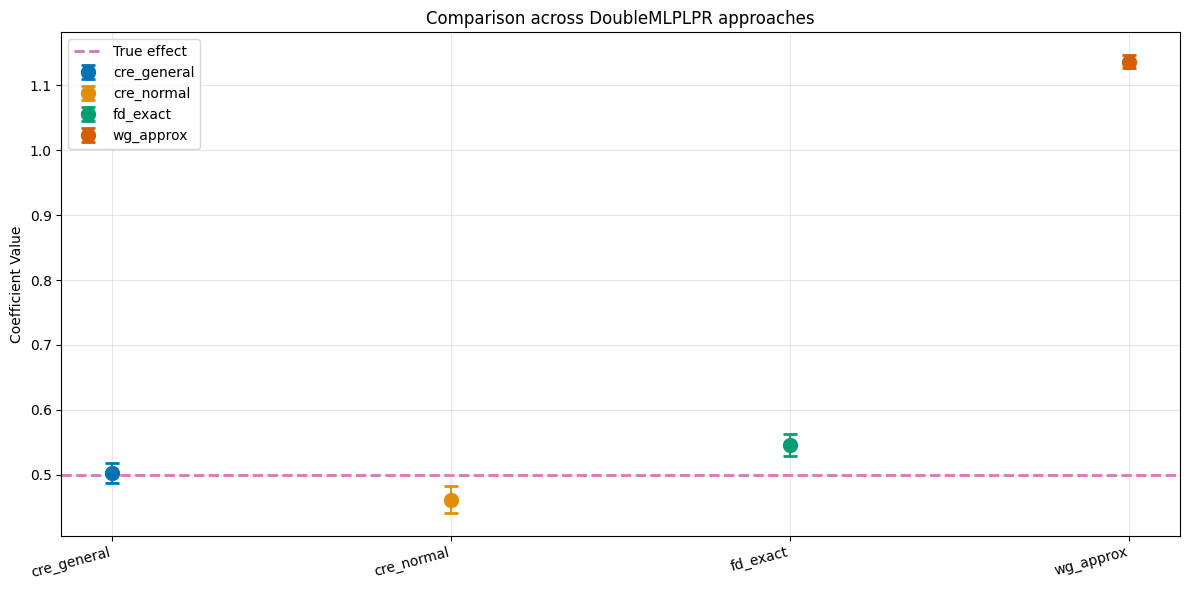

In [37]:
palette = sns.color_palette("colorblind")

ci_cre_general = plpr_tune_cre_general.confint()
ci_cre_normal = plpr_tune_cre_normal.confint()
ci_fd = plpr_tune_fd.confint()
ci_wg = plpr_tune_wg.confint()

comparison_data = {
    "Model": ["cre_general", "cre_normal", "fd_exact", "wg_approx"],
    "theta": [plpr_tune_cre_general.coef[0], plpr_tune_cre_normal.coef[0], plpr_tune_fd.coef[0], plpr_tune_wg.coef[0]],
    "se": [plpr_tune_cre_general.se[0], plpr_tune_cre_normal.se[0], plpr_tune_fd.se[0], plpr_tune_wg.se[0]],
    "ci_lower": [ci_cre_general.iloc[0, 0], ci_cre_normal.iloc[0, 0], ci_fd.iloc[0, 0], ci_wg.iloc[0, 0]],
    "ci_upper": [ci_cre_general.iloc[0, 1], ci_cre_normal.iloc[0, 1], ci_fd.iloc[0, 1], ci_wg.iloc[0, 1]]
}
df_comparison = pd.DataFrame(comparison_data)

print(f"True treatment effect: {theta}\n")
print(df_comparison.to_string(index=False))

# Create comparison plot 
plt.figure(figsize=(12, 6))

for i in range(len(df_comparison)):
    plt.errorbar(i, df_comparison.loc[i, "theta"],
                 yerr=[[df_comparison.loc[i, "theta"] - df_comparison.loc[i, "ci_lower"]],
                       [df_comparison.loc[i, "ci_upper"] - df_comparison.loc[i, "theta"]]],
                 fmt='o', capsize=5, capthick=2, ecolor=palette[i], color=palette[i],
                 label=df_comparison.loc[i, "Model"], markersize=10, zorder=2)
plt.axhline(y=theta, color=palette[4], linestyle='--',
            linewidth=2, label="True effect", zorder=1)

plt.title("Comparison across DoubleMLPLPR approaches")
plt.ylabel("Coefficient Value")
plt.xticks(range(4), df_comparison["Model"], rotation=15, ha="right")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We again see that the `wg_approx` leads to a biased estimate in the non-linear and discontinuous `dgp3` setting. The approaches `cre_general`, `cre_normal`, `fd_exact`, in combination with [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressors, tuned using the [Optuna](https://optuna.org/) package, lead to estimate close to the true treatment effect.

This is line with the simulation results in [Clarke and Polselli (2025)](https://doi.org/10.1093/ectj/utaf011), albeit only for only one dataset in this example.